In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# === Load Dataset ===
df = pd.read_csv(r"C:\Users\Administrator\Desktop\Saif\CIC_Modbus_Research\Final_Clean_Merged\multiclass\preprocessed_dataset_final.csv")
X = df.drop("Attack_enc", axis=1)
y = df["Attack_enc"]

# === Split and Scale ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# Compute class imbalance ratios
from collections import Counter
class_counts = Counter(y_train)
total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate weights: total / (num_classes * count_per_class)
scale_pos_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
print("📊 Class Weights (scale_pos_weight):", scale_pos_weights)


📊 Class Weights (scale_pos_weight): {0: 0.08036748212391387, 5: 0.9396065288192078, 7: 3.03947690799951, 2: 2.238575359769026, 17: 3.9552446995058186, 13: 4.523060796645702, 3: 1.961441163682359, 14: 1.5588383124430623, 8: 4.887953112687155, 6: 3.4676799440950385, 10: 4.806984403758597, 1: 2.6242794436511714, 16: 3.4034636488340193, 9: 3.430996335476734, 11: 4.962746274627463, 12: 24.948466566113623, 15: 5.541317699609157, 4: 393.82936507936506}


In [7]:
# Map each sample to its class weight
sample_weights = np.array([scale_pos_weights[int(cls)] for cls in y_train])

# Train weighted XGBoost
xgb_weighted = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Save model and scaler
joblib.dump(xgb_weighted, r"C:\Users\Administrator\Desktop\Saif\CIC_Modbus_Research\Final_Clean_Merged\multiclass\xgboost_model_weighted.pkl")
joblib.dump(scaler, r"C:\Users\Administrator\Desktop\Saif\CIC_Modbus_Research\Final_Clean_Merged\multiclass\global_scaler_xgb_weighted.pkl")


C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:22:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['C:\\Users\\Administrator\\Desktop\\Saif\\CIC_Modbus_Research\\Final_Clean_Merged\\multiclass\\global_scaler_xgb_weighted.pkl']

In [8]:
# === Predict and Evaluate ===
y_pred = xgb_weighted.predict(X_test_scaled)
y_prob = xgb_weighted.predict_proba(X_test_scaled)
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision (Macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
    "Recall (Macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
    "F1-Score (Macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
    "ROC-AUC (Macro)": roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr'),
    "ROC-AUC (Micro)": roc_auc_score(y_test_bin, y_prob, average='micro', multi_class='ovr'),
}

# Raw per-class scores
precision_raw = precision_score(y_test, y_pred, average=None, zero_division=0)
recall_raw = recall_score(y_test, y_pred, average=None, zero_division=0)
f1_raw = f1_score(y_test, y_pred, average=None, zero_division=0)

# === Print Results ===
summary_df = pd.DataFrame(results.items(), columns=["Metric", "Value"])
print("✅ Weighted XGBoost Evaluation Summary:")
display(summary_df)

print("\n📊 Raw Per-Class Scores:")
print(f"Precision: {np.round(precision_raw, 3)}")
print(f"Recall:    {np.round(recall_raw, 3)}")
print(f"F1-Score:  {np.round(f1_raw, 3)}")


✅ Weighted XGBoost Evaluation Summary:


,Metric,Value
0,Accuracy,0.846006
1,Precision (Macro),0.470073
2,Recall (Macro),0.490679
3,F1-Score (Macro),0.472503
4,ROC-AUC (Macro),0.965034
5,ROC-AUC (Micro),0.990540



📊 Raw Per-Class Scores:
Precision: [0.997 0.379 0.398 0.777 0.333 0.93  0.475 0.327 0.34  0.339 0.297 0.342
 0.343 0.316 0.945 0.238 0.355 0.33 ]
Recall:    [0.982 0.337 0.35  0.611 0.167 0.74  0.475 0.38  0.48  0.379 0.447 0.471
 0.521 0.456 0.866 0.351 0.409 0.409]
F1-Score:  [0.99  0.357 0.372 0.684 0.222 0.824 0.475 0.352 0.398 0.358 0.357 0.396
 0.414 0.373 0.904 0.284 0.38  0.365]


In [2]:
# Step 1: Load the model and scaler
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv(r"C:\Users\Administrator\Desktop\Saif\CIC_Modbus_Research\Final_Clean_Merged\multiclass\preprocessed_dataset_final.csv")
X = df.drop("Attack_enc", axis=1)
y = df["Attack_enc"]

# Load scaler and weighted XGB model
scaler = joblib.load(r"C:\Users\Administrator\Desktop\Saif\CIC_Modbus_Research\Final_Clean_Merged\multiclass\global_scaler_xgb_weighted.pkl")
xgb_weighted = joblib.load(r"C:\Users\Administrator\Desktop\Saif\CIC_Modbus_Research\Final_Clean_Merged\multiclass\xgboost_model_weighted.pkl")

# Apply scaling
X_scaled = scaler.transform(X)

# Split train/test with same stratification
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# Predict
y_pred_xgb = xgb_weighted.predict(X_test_scaled)


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


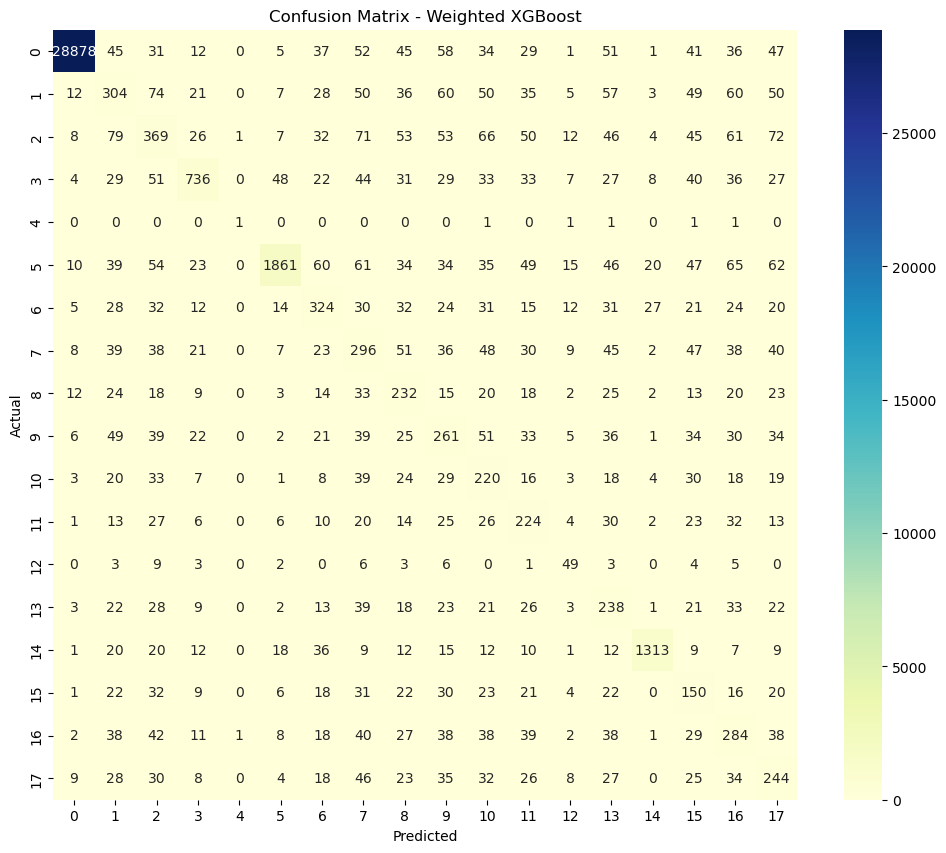

In [3]:
# Step 2: Generate the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Weighted XGBoost')
plt.show()


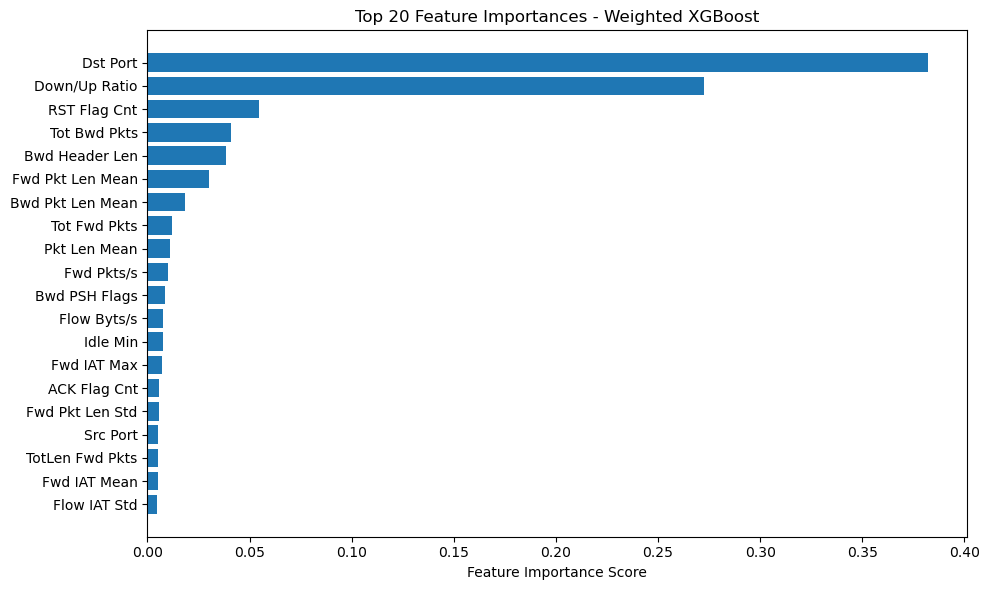

In [4]:
# Step 3: Generate the Top 20 Feature Importances
import numpy as np

importances_xgb = xgb_weighted.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1][:20]  # Top 20 features
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), [features[i] for i in indices_xgb])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance Score")
plt.title("Top 20 Feature Importances - Weighted XGBoost")
plt.tight_layout()
plt.show()
